In [16]:
import cv2 as cv
import numpy as np
import glob
import pickle
import ml_metrics
import math
import pandas as pd
import os
import yaml
import matplotlib.pyplot as plt
from evaluation_funcs import performance_accumulation_pixel
from evaluation_funcs import performance_evaluation_pixel
from bbox_iou import bbox_iou

## PARAMETERS ##
with open("config.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

if cfg['colorspace'] == 'HSV' :
    COLORSPACE = cv.COLOR_BGR2HSV
elif cfg['colorspace'] == 'YUV' :
    COLORSPACE = cv.COLOR_BGR2YUV
elif cfg['colorspace'] == 'LAB' :
    COLORSPACE = cv.COLOR_BGR2Lab

NBINS = cfg['nbins']    # Number of bins (from 0 to 255)
DIVISIONS = cfg['divs'] # Number of divisions per dimension [2,4,8,...]
DIST_METRIC= cfg['dist'] #'euclidean' 'chisq' or 'hellinger'
BG_REMOVAL = cfg['bgrm'] # 1, 2 or 3 bg removal method
QUERY_SET= cfg['queryset'] # Input query set

K = 3

In [3]:
## FUNCTIONS ##
def text_removal_mask(img_gray, name, strel, strel_pd, num_cols, coords, bg_mask):

    if np.shape(bg_mask)[0] == 2:
        print("HOLA")
        plt.imshow(bg_mask[0])
        plt.show()

        plt.imshow(bg_mask[1])
        plt.show()

    # Obtain image dimensions
    height,width = img_gray.shape[:2]
    
    # Create variable where final mask will be stored
    f_mask = np.ones(shape=(height,width))
    f_mask.fill(255)
    
    # Boundaries of the analyzed area
    min_a = round(width/2)
    max_a = round(min_a + num_cols)
    
    # Store pixel values in the analyzed area
    values_t = np.zeros(shape=(max_a-min_a, max_a-min_a))
    
    i = 0
    
    for p in range(min_a, max_a):
        # Per each column, compute number of ocurrences of every pixel value
        col = img_gray[:,p]
        
        # Pixel values and number of ocurrences for the whole column
        values = pd.Series(col).value_counts().keys().tolist()
        
        # Get highest pixel values (most frequent ones)
        values_t[0:4,i] = values[0:4]

        i += 1

    j = 0
    w = 0
    h = 0

    while((w*h < 20000 or w*h > 1000000 or w<h) and j < num_cols):

        level = round(np.mean(values_t[j,:]))
        
        if level <= 128:
            final_img = cv.morphologyEx(img_gray, cv.MORPH_OPEN, strel)
            mask = (final_img >= max(0,level-1)) * (final_img <= level+1)
            mask = mask.astype(np.uint8)
            mask *= 255
        elif level > 128:
            final_img = cv.morphologyEx(img_gray, cv.MORPH_CLOSE, strel)
            mask = (final_img >= max(0,level-1)) * (final_img <= level+1)
            mask = mask.astype(np.uint8)
            mask *= 255

        #mask = cv.morphologyEx(mask, cv.MORPH_OPEN, np.ones((2,2), np.uint8))   

        if np.sum(mask) != 0:

            # Find contours of created mask
            contours,_ = cv.findContours(mask, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)

            # Find largest contour (it will contain the text bounding box)
            contour_sizes = [(cv.contourArea(contour), contour) for contour in contours]
            largest_contour = max(contour_sizes, key=lambda x: x[0])[1]
            
            # Find bounding box belonging to detected contour
            (x,y,w,h) = cv.boundingRect(largest_contour)

            # Draw bounding boxes coordinates on original image to visualize it
            cv.rectangle(img_gray, (x,y), (x+w,y+h), (0,255,0), 2)
            
            # Bboxes coordinates of the text positions
            tlx = x
            tly = y
            brx = x + w
            bry = y + h

            # Extract bounding boxes pixels 
            bb_size = w*h

        j+=1

    # Add bboxes coordinates to a list of lists
    coords.append([(tlx,tly,brx,bry)])

    # Create new mask with bboxes coordinates
    # Bboxes pixels are black (text), white otherwise (painting)
    f_mask[y:y + h, x:x + w] = 0

    cv.imwrite('results/'+ name + 'txtrmask.png', f_mask)
    
    return f_mask, coords

In [4]:
def compute_mask(img,name):
    height, width = np.shape(img)

    # METHOD 3 BASED ON MORPHOLOGY
    if(BG_REMOVAL==3):
        # Compute morphological gradient by dilation (keep inner edges to remove wall posters)
        kernel = np.ones((40,40),np.uint8)
        img_dilation = cv.dilate(img,kernel,iterations = 1)
        img_gradient = img_dilation - img
        
        # Thresholding
        _,img_th = cv.threshold(img_gradient, 30, 255, cv.THRESH_BINARY)
        #retval,mask_img = cv.threshold(final_img, 30, 255, cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

        # Computing external contours
        contours, _ = cv.findContours(img_th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
        img_contour = np.zeros_like(img_th)
        cv.drawContours(img_contour, contours, -1, 255, -1)
        
        # Opening to remove wall posters
        kernel = np.ones((100,200),np.uint8)
        mask = cv.morphologyEx(img_contour, cv.MORPH_OPEN, kernel)

        # Avoid all zeros image
        if(mask.any()==0):
            mask = img_contour

    # METHODS 1 AND 2 BASED ON COLOR THRESHOLDING
    else:
        # Computes channels in chosen color space
        c0 = img[:,:,0]
        c1 = img[:,:,1]
        c2 = img[:,:,2]
            
        # Percentage defining number of pixels per every portion of the image
        percent_c0 = 0.02
        percent_c1 = 0.03
        percent_c2 = 0.02
        
        # Computes the amount of pixels per every channel
        aop_h_c0 = int(round(percent_c0 * height))
        aop_w_c0 = int(round(percent_c0 * width))
        
        aop_h_c1 = int(round(percent_c1 * height))
        aop_w_c1 = int(round(percent_c1 * width))
        
        aop_h_c2 = int(round(percent_c2 * height))
        aop_w_c2 = int(round(percent_c2 * width))
        
        # Defines image portions to get background pixels from
        portionc0_1 = c0[0:aop_h_c0, 0:width]
        portionc1_1 = c1[0:aop_h_c1, 0:width]
        portionc2_1 = c2[0:aop_h_c2, 0:width]
        
        if(BG_REMOVAL == 1) :
            # Method 1
            portionc0_2 = c0[height - aop_h_c0:height, 0:width]
            portionc1_2 = c1[height - aop_h_c1:height, 0:width]
            portionc2_2 = c2[height - aop_h_c2:height, 0:width]
        elif(BG_REMOVAL == 2):    
            # Method 2
            portionc0_2 = c0[0:height,0:aop_w_c0]
            portionc1_2 = c1[0:height,0:aop_w_c1]
            portionc2_2 = c2[0:height,0:aop_w_c2]
        
        # Computes minimum and max values per every portion and channel
        min_c0_1 = int(np.amin(portionc0_1))
        min_c1_1 = int(np.amin(portionc1_1))
        min_c2_1 = int(np.amin(portionc2_1))
        
        min_c0_2 = int(np.amin(portionc0_2))
        min_c1_2 = int(np.amin(portionc1_2))
        min_c2_2 = int(np.amin(portionc2_2))
        
        max_c0_1 = int(np.amax(portionc0_1))
        max_c1_1 = int(np.amax(portionc1_1))
        max_c2_1 = int(np.amax(portionc2_1))
        
        max_c0_2 = int(np.amax(portionc0_2))
        max_c1_2 = int(np.amax(portionc1_2))
        max_c2_2 = int(np.amax(portionc2_2))
        
        min_c0 = min(min_c0_1, min_c0_2)
        min_c1 = min(min_c1_1, min_c1_2)
        min_c2 = min(min_c2_1, min_c2_2)
        
        max_c0 = max(max_c0_1, max_c0_2)
        max_c1 = max(max_c1_1, max_c1_2)
        max_c2 = max(max_c2_1, max_c2_2)
        
        # Computes and saves the mask by thresholding every channel in the chosen color space
        mask = 255 - (cv.inRange(img,(min_c0, min_c1, min_c2),(max_c0, max_c1, max_c2)))

    # Save mask
    cv.imwrite('masks/' + name + '.png', mask)
    
    # Read ground truth
    g_t = cv.imread('../qs/' + QUERY_SET + '/' + name + '.png', cv.IMREAD_COLOR)
    g_t = cv.cvtColor(g_t, cv.COLOR_BGR2GRAY)
    
    # Compute evaluation metrics
    pixelTP, pixelFP, pixelFN, pixelTN = performance_accumulation_pixel(mask,g_t)
    pixel_precision, pixel_accuracy, pixel_specificity, pixel_sensitivity = performance_evaluation_pixel(pixelTP, pixelFP, pixelFN, pixelTN)
    F1 = 2*pixel_precision*pixel_sensitivity/(pixel_precision+pixel_sensitivity)
    
    eval_metrics = [pixel_precision, pixel_accuracy, pixel_specificity, pixel_sensitivity, F1]
    '''
    print("Precision: "+str(pixel_precision))
    print("Accuracy: "+str(pixel_accuracy))
    print("Specificity: "+str(pixel_specificity))
    print("Recall (sensitivity): "+str(pixel_sensitivity))
    print("F1: "+str(F1))
    '''

    # DETECT IF THERE ARE TWO IMAGES
    # First method: check if the central mask is black
    central_column = round(width/2)
    central_column_mean = np.mean(mask[:,central_column:central_column+1])
    
    # If central column is not zero, analyze some extra columns
    # From 0.25 to 0.75 of the image, with a step of 100px
    if central_column_mean != 0:
        for i in range(round(0.5*(width/2)), round(1.5*(width/2)), 100):
            central_column_mean = np.mean(mask[:,i:i+1])
            if (central_column_mean == 0): # If found, exit for and keep central_column
                central_column = i
                break

    # If after the second attempt two masks are detected 
    if central_column_mean == 0:
        # Generate white masks
        mask_left = np.ones((height,width),np.uint8)
        mask_right = np.ones((height,width),np.uint8)
        
        # Compute
        mask_left[:,central_column:width] = 0
        mask_right[:,0:central_column] = 0
        mask_left = mask_left*mask
        mask_right = mask_right*mask
        mask = [mask_left, mask_right]        
    
    return mask, eval_metrics

In [5]:
def extract_features(img,mask):

#Extracts feature vector from image. The returned vecor consists of the 1D histograms of
# each of the image channels concatenated.
    
    # Mask preprocessing
    if mask is not None:
        indices = np.where(mask != [0])
        img = img[min(indices[0]):max(indices[0]),min(indices[1]):max(indices[1])]
        mask = mask[min(indices[0]):max(indices[0]),min(indices[1]):max(indices[1])]

    # Level 0 histograms:
    hist_img = []
    npx = img.shape[0]*img.shape[1]
    hist_1 = cv.calcHist([img],[0],mask,[NBINS],[0,256])/npx 
    hist_2 = cv.calcHist([img],[1],mask,[NBINS],[0,256])/npx
    hist_3 = cv.calcHist([img],[2],mask,[NBINS],[0,256])/npx
    hists = np.concatenate((hist_1,hist_2,hist_3))
    hist_img.append(hists)

    # Multilevel histograms
    for i in range(0,DIVISIONS):
        for j in range(0,DIVISIONS):
            # Compute the normalized histograms
            subimg = img[i*round(img.shape[0]/DIVISIONS):(i+1)*round(img.shape[0]/DIVISIONS)-1, 
                         j*round(img.shape[1]/DIVISIONS):(j+1)*round(img.shape[1]/DIVISIONS)-1]
            if mask is not None :
                submask = mask[i*round(img.shape[0]/DIVISIONS):(i+1)*round(img.shape[0]/DIVISIONS)-1, 
                            j*round(img.shape[1]/DIVISIONS):(j+1)*round(img.shape[1]/DIVISIONS)-1]
            else :
                submask = None
            npx = subimg.shape[0]*subimg.shape[1]
            hist_1 = cv.calcHist([subimg],[0],submask,[NBINS],[0,256])/npx 
            hist_2 = cv.calcHist([subimg],[1],submask,[NBINS],[0,256])/npx
            hist_3 = cv.calcHist([subimg],[2],submask,[NBINS],[0,256])/npx
            hists = np.concatenate((hist_1,hist_2,hist_3))
            hist_img.append(hists)
    flat_list = []
    for sublist in hist_img:
        for item in sublist:
            flat_list.append(item)
    return flat_list



In [6]:
def search(queries, database, distance, k):

# For each of the queries, searches for the K  most similar images in the database. The
#decision is based on the feature vectors and a distance or similarity measure (Euclidean
# distance and Hellinger Kernel similarity. Returns a 2D array containing the results of
#the search for each of the queries.

    final_ranking = np.zeros((len(queries), k), dtype=float)
    
    if(distance == "euclidean"):
        for i in range(0, len(queries)):
            ranking = np.ones((k, 2), dtype=float) * 9999
            for j in range(0, len(database)):
                # Compute the distance metric
                dist = sum(pow(abs(np.array(database[j]) - np.array(queries[i])), 2))
                # Check the ranking and update it
                if (dist < max(ranking[:, 1])):
                    # Add the distance and the id to the db
                    idx = np.argmax(ranking[:, 1])
                    ranking[idx, 0] = j
                    ranking[idx, 1] = dist
            # Store the closest K images
            for j in range(0, k):
                idx = np.argmin(ranking[:, 1])
                final_ranking[i, j] = ranking[idx, 0]
                ranking[idx, :] = [9999, 9999]

    if(distance == "chisq"):
            for i in range(0, len(queries)):
                ranking = np.ones((k, 2), dtype=float) * 9999
                for j in range(0, len(database)):
                    # Compute the distance metric
                    dist = sum( np.divide(pow(abs(database[j] - queries[i]), 2), (database[j] + queries[i]), out=np.zeros_like(database[j]), where=queries[i]!=0) )
                    # Check the ranking and update it
                    if (dist < max(ranking[:, 1])):
                        # Add the distance and the id to the db
                        idx = np.argmax(ranking[:, 1])
                        ranking[idx, 0] = j
                        ranking[idx, 1] = dist
                # Store the closest K images
                for j in range(0, k):
                    idx = np.argmin(ranking[:, 1])
                    final_ranking[i, j] = ranking[idx, 0]
                    ranking[idx, :] = [9999, 9999]

    if(distance == "hellinger"):
        for i in range(0, len(queries)):
            ranking = np.zeros((k, 2), dtype=float)
            for j in range(0, len(database)):
                # Compute the distance metric
                dist = np.sum(np.sqrt(np.multiply(np.array(database[j]),np.array(queries[i]))))
                # Check the ranking and update it
                if (dist > min(ranking[:, 1])):
                    # Add the distance and the id to the db
                    idx = np.argmin(ranking[:, 1])
                    ranking[idx, 0] = j
                    ranking[idx, 1] = dist
            # Store the closest K images
            for j in range(0, k):
                idx = np.argmax(ranking[:, 1])
                final_ranking[i, j] = ranking[idx, 0]
                ranking[idx, :] = [0, 0]

    return final_ranking

In [37]:
database = []
for f in sorted(glob.glob('../database/*.jpg')):
    img = cv.imread(f, cv.IMREAD_COLOR)
    img = cv.cvtColor(img, COLORSPACE)
    database.append(extract_features(img,None))
print('Database has ' + str(len(database)) + ' images')

queries = []

qs_l = '../qs/' + QUERY_SET + '/*.jpg'

# Evaluation metrics storing arrays
precision = np.zeros(len(glob.glob(qs_l)))
recall = np.zeros(len(glob.glob(qs_l)))
fscore = np.zeros(len(glob.glob(qs_l)))
iou = np.zeros(len(glob.glob(qs_l)))

i=0

# Text removal variables
# Structuring element
strel = np.ones((15,15), np.uint8)

# Structuring element used after text removal
strel_pd = np.ones((20,20),np.uint8)

# Number of columns considered from the center of the image towards the right
num_cols = 6

# List to store detected bounding boxes coordinates
coords = []

for f in sorted(glob.glob(qs_l)):
    name = os.path.splitext(os.path.split(f)[1])[0]
    im = cv.imread(f, cv.IMREAD_COLOR)
    img = cv.cvtColor(im, COLORSPACE)

    # NO BACKGROUND
    if QUERY_SET == 'qsd1_w1' or QUERY_SET == 'qst1_w1' or QUERY_SET == 'qsd1_w2' or QUERY_SET == 'qst1_w2':
        bg_mask = None
    # BACKGROUND REMOVAL
    elif QUERY_SET == 'qsd2_w1' or QUERY_SET == 'qst2_w1' or QUERY_SET == 'qsd2_w2' or QUERY_SET == 'qst2_w2':
        if BG_REMOVAL==3:
            img_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
            bg_mask, eval_metrics = compute_mask(img_gray,name)
        else:
            bg_mask, eval_metrics = compute_mask(img,name)
        precision[i] = eval_metrics[0]
        recall[i] = eval_metrics[3]
        fscore[i] = eval_metrics[4]

    # TEXT REMOVAL
    if QUERY_SET == 'qsd1_w2' or QUERY_SET == 'qst1_w2' or QUERY_SET == 'qsd2_w2' or QUERY_SET == 'qst2_w2':
        img_gray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
        # Use the mask created (image without background) to indicate search area
        mask, pred_coords = text_removal_mask(img_gray, name, strel, strel_pd, num_cols, coords, bg_mask)
        mask = mask.astype(np.uint8)
    else:
        mask = bg_mask

    i+=1

    
    # Iterate the masks (1 or 2 according to the images)
    query_data = []
    for m in mask:
        query_data.append(extract_features(img,m))

    queries.append(query_data)

Database has 279 images


IndexError: tuple index out of range

(1178, 1159)


TypeError: Invalid dimensions for image data

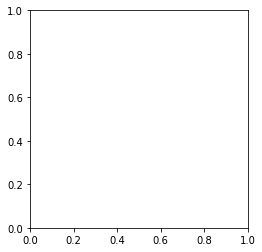

In [38]:
print(np.shape(bg_mask))
plt.imshow(bg_mask[0])
plt.show()
plt.imshow(bg_mask[1])
plt.show()

# Iterate the masks (1 or 2 according to the images)
query_data = []
for m in bg_mask:
    query_data.append(extract_features(img,m))

queries.append(query_data)

In [35]:
print(np.shape(query_data))
print(np.shape(queries))
print(str(len(queries)))

(2, 19392, 1)
(2,)
2


In [ ]:
if QUERY_SET == 'qsd2_w1':
    print('Query set has ' + str(len(queries)) + ' images')
    print('Precision: ' + str(np.mean(precision)))
    print('Recall: ' + str(np.mean(recall)))
    print('F-measure: ' + str(np.mean(fscore)))

if (QUERY_SET == 'qsd1_w2' or QUERY_SET == 'qst1_w2'):
    realcoords = pickle.load(open(QUERY_SET + '/text_boxes.pkl','rb'))
    i = 0
    for i in range(0, len(realcoords)):
        real = coords[i][0]
        predicted = realcoords[i][0]
        iou[i] = bbox_iou(real, predicted)
        i += 1
    print('Mean IOU: ' + str(np.mean(iou)))

    ## WRITE PREDICTED BOUNDING BOXES ##
    pickle.dump(pred_coords, open('../qs/' + QUERY_SET + '/pred_bboxes.pkl','wb'))

## ADD QSD2_W2 AND QST2_W2

## SEARCH FOR THE QUERIES IN THE DB ##
final_ranking = search(queries, database, DIST_METRIC, K)
print('FINAL RANKING:')
print(final_ranking)

## EVALUATION USING MAP@K ##
if QUERY_SET == 'qsd1_w1' or QUERY_SET == 'qsd2_w1'  or QUERY_SET == 'qsd1_w2' or QUERY_SET == 'qsd2_w2':
    gt = pickle.load(open('../qs/' + QUERY_SET + '/gt_corresps.pkl','rb'))
    mapk_ = ml_metrics.mapk(gt,final_ranking.tolist(),K)
    print('MAP@K = '+ str(mapk_))

## WRITE OUTPUT FILES ##
pickle.dump(final_ranking.tolist(), open('../qs/' + QUERY_SET + '/actual_corresps.pkl','wb'))
